In [ ]:
!python3 -m pip install xlrd --user

In [3]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import eigh
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.cluster import KMeans

## Data Preperation

In [5]:
cols = ['Word Count',
 'Length',
 'Syllable Count',
 'Vowel Count',
 'Consonent Count',
 'Created Since',
 'Updated Since',
 'Registrar',
 'TTL',
 'IANA',
 'Unique Letter',
 'Hyphen',
 'Underscore', 'Type']

In [6]:
feature_cols = ['Word Count',
 'Length',
 'Syllable Count',
 'Vowel Count',
 'Consonent Count',
 'Created Since',
 'Updated Since',
 'Registrar',
 'TTL',
 'IANA',
 'Unique Letter',
 'Hyphen',
 'Underscore']

In [7]:
df = pd.read_csv('DiffusionMapTrainig.csv', usecols=cols)

In [8]:
X_small, X_large = train_test_split(df, stratify=df['Type'], test_size=0.8)

In [9]:
X_small.shape

(4800, 14)

In [10]:
X = X_small[feature_cols]

In [11]:
X.head()

,Word Count,Length,Syllable Count,Vowel Count,Consonent Count,Created Since,Updated Since,Registrar,TTL,IANA,Unique Letter,Hyphen,Underscore
6149,3,20,5,7,9,2188,2185,0,0,0,12,0,0
20436,2,18,4,4,8,375,372,0,0,0,8,0,0
16779,3,29,9,9,15,564,552,0,0,0,14,0,0
6890,3,23,7,8,11,2200,2197,0,0,0,13,0,0
10461,2,17,4,4,9,2150,2147,0,0,0,10,0,0


In [12]:
y = pd.DataFrame(X_small['Type'])

In [13]:
y.head()

,Type
6149,matsnu
20436,suppobox
16779,gozi
6890,matsnu
10461,matsnu


In [14]:
scalar = StandardScaler().fit(X)

In [15]:
X_transformed = pd.DataFrame(scalar.transform(X))

In [16]:
classes = ['benign', 'matsnu', 'gozi', 'suppobox']

## Finding Diffusion Matrix

In [17]:
def find_diffusion_matrix(X=None, alpha=0.15):
    """Function to find the diffusion matrix P
        
        >Parameters:
        alpha - to be used for gaussian kernel function
        X - feature matrix as numpy array
        
        >Returns:
        P_prime, P, Di, K, D_left
    """
    alpha = alpha
        
    dists = euclidean_distances(X, X)
    K = np.exp(-dists**2 / alpha)
    
    r = np.sum(K, axis=0)
    Di = np.diag(1/r)
    P = np.matmul(Di, K)
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))

    return P_prime, P, Di, K, D_left

## Finding Diffusion Map

In [18]:
def find_diffusion_map(P_prime, D_left, n_eign=3):
    """Function to find the diffusion coordinates in the diffusion space
        
        >Parameters:
        P_prime - Symmetrized version of Diffusion Matrix P
        D_left - D^{-1/2} matrix
        n_eigen - Number of eigen vectors to return. This is effectively 
                    the dimensions to keep in diffusion space.
        
        >Returns:
        Diffusion_map as np.array object
    """   
    n_eign = n_eign
    
    eigenValues, eigenVectors = eigh(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    diffusion_coordinates = np.matmul(D_left, eigenVectors)
    
    return diffusion_coordinates[:,:n_eign]

## From mapalign diffusion map library of sklearn developer

In [19]:
from mapalign.embed import DiffusionMapEmbedding

In [26]:
def compare_methods(X, title, cluster=None):
    f, axarr = plt.subplots(2, 7, sharex=True, sharey=True, figsize=(15, 5))
    for idx, t in enumerate([0, 0.1, 1, 10, 100, 250, 1000]):
        de = DiffusionMapEmbedding(alpha=0.5, diffusion_time=t, affinity='markov',
                                   n_components=10).fit_transform(X.copy())
        ed = (de - de[0, :])
        ed = np.sqrt(np.sum(ed * ed , axis=1))
        ed = ed/max(ed)
        if cluster is not None:
            ed = KMeans(n_clusters=cluster).fit(de).labels_
        plt.axes(axarr[0][idx])
        if cluster is not None: 
            plt.scatter(X[:, 0], X[:, 1], c=ed, cmap=plt.cm.Set1, linewidths=0)
        else:
            plt.scatter(X[:, 0], X[:, 1], c=ed, cmap=plt.cm.Spectral, linewidths=0)
        plt.axis('tight')
        if cluster is None:
            plt.colorbar()
        plt.title('t={:g}'.format(t))
    for idx, c in enumerate([2, 3, 4, 5, 10, 20, 50]):
        se = SpectralEmbedding(n_components=c).fit_transform(X.copy())
        ed = (se - se[0, :])
        ed = np.sqrt(np.sum(ed * ed , axis=1))
        ed = ed/max(ed)
        if cluster is not None:
            ed = KMeans(n_clusters=cluster).fit(ed[:, None]).labels_
        plt.axes(axarr[1][idx])
        if cluster is not None: 
            plt.scatter(X[:, 0], X[:, 1], c=ed, cmap=plt.cm.Set1, linewidths=0)
        else:
            plt.scatter(X[:, 0], X[:, 1], c=ed, cmap=plt.cm.Spectral, linewidths=0)
        plt.axis('tight')
        if cluster is None:
            plt.colorbar()
        plt.title('num_c=%d' % (c))
    ph = plt.suptitle(title)

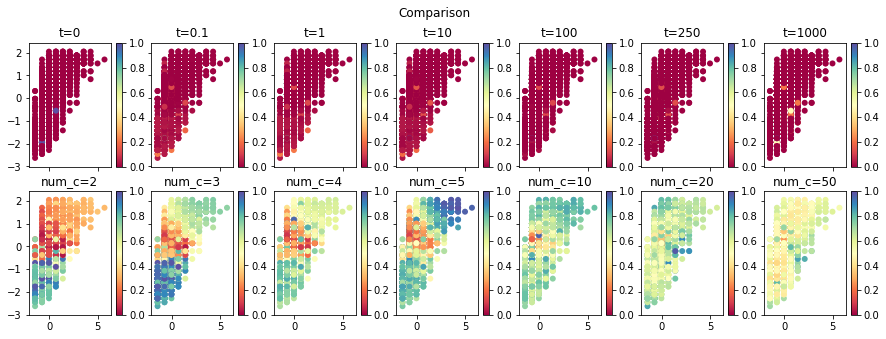

In [27]:
compare_methods(np.asarray(X_transformed), 'Comparison')

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X_transformed, alpha=0.15)

In [ ]:
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)

In [ ]:
y.values

## 3D Plotting

In [ ]:
def plotly3D(d_map, y, title='Interactive Cluster Shapes in 3D'):
    # Visualize cluster shapes in 3d.
    
    def rename_columns(df, prefix='x'):
        df = df.copy()
        df.columns = [prefix + str(i) for i in df.columns]
        return df
    
    X, Y = d_map, y
    df = pd.DataFrame(X)
    # rename X columns
    df = rename_columns(df)
    # and add the Y
    df['y'] = Y
    print(df.head())
    # ['benign', 'matsnu', 'gozi', 'suppobox']
    cluster1=df.loc[df['y'] == 'benign']
    cluster2=df.loc[df['y'] == 'matsnu']
    cluster3=df.loc[df['y'] == 'gozi']
    cluster4=df.loc[df['y'] == 'suppobox']
    
    # cluster3=df.loc[df['y'] == 2]

    scatter1 = dict(mode = "markers",name = "benign",type = "scatter3d",    
        x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
        marker = dict( size=2, color='red')
    )
    scatter2 = dict(mode = "markers",name = "matsnu",type = "scatter3d",    
        x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
        marker = dict( size=2, color='blue')
    )

    scatter3 = dict(mode = "markers",name = "gozi",type = "scatter3d",    
        x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
        marker = dict( size=2, color='green')
    )
    scatter4 = dict(mode = "markers",name = "suppobox",type = "scatter3d",    
        x = cluster4.as_matrix()[:,0], y = cluster4.as_matrix()[:,1], z = cluster4.as_matrix()[:,2],
        marker = dict( size=2, color='black')
    )
    layout = dict(
        title = title,
        scene = dict(
            xaxis = dict( zeroline=True ),
            yaxis = dict( zeroline=True ),
            zaxis = dict( zeroline=True )),
        height=700)
    fig = dict( data=[scatter1, scatter2, scatter3, scatter4], layout=layout )
    plotly.offline.iplot(fig, filename='mesh3d_sample')
#     plotly.iplot(fig)

In [ ]:
plotly3D(d_map, y.values, title='Cluster in 3D with alpha=0.15')

In [ ]:
def rename_columns(df, prefix='x'):
        df = df.copy()
        df.columns = [prefix + str(i) for i in df.columns]
        return df
    
X, Y = d_map, y.values
df = pd.DataFrame(X)
# rename X columns
df = rename_columns(df)
# and add the Y
df['y'] = Y

In [ ]:
df[df['y']=='gozi'].count()

## Plotting with different values of alpha

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=0.5)

In [ ]:
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)

In [ ]:
plotly3D(d_map, y, title='Cluster in 3D with alpha=0.5')

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=0.005)
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)
plotly3D(d_map, y, title='Cluster in 3D with alpha=0.005')

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=0.001)
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)
plotly3D(d_map, y, title='Cluster in 3D with alpha=0.001')

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=0.002)
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)
plotly3D(d_map, y, title='Cluster in 3D with alpha=0.002')

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=0.8)
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)
plotly3D(d_map, y, title='Cluster in 3D with alpha=0.8')

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=1)
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)
plotly3D(d_map, y, title='Cluster in 3D with alpha=1')

## Plotting Unsupervised clustering using KMeans 

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

In [ ]:
#Kmeans prediction on 3D diffusion space 
y_km = km.fit_predict(d_map)

In [ ]:
y_km

In [ ]:
def plotly3D_Kmeans(d_map, y, title='Interactive Cluster Shapes in 3D'):
    # Visualize cluster shapes in 3d.
    
    def rename_columns(df, prefix='x'):
        df = df.copy()
        df.columns = [prefix + str(i) for i in df.columns]
        return df
    
    X, Y = d_map, y
    df = pd.DataFrame(X)
    # rename X columns
    df = rename_columns(df)
    # and add the Y
    df['y'] = Y
    print(df.head())
    # ['benign', 'matsnu', 'gozi', 'suppobox']
    cluster1=df.loc[df['y'] == 0]
    cluster2=df.loc[df['y'] == 1]
    cluster3=df.loc[df['y'] == 2]
    cluster4=df.loc[df['y'] == 3]
    
    # cluster3=df.loc[df['y'] == 2]

    scatter1 = dict(mode = "markers",name = "benign",type = "scatter3d",    
        x = cluster1.as_matrix()[:,0], y = cluster1.as_matrix()[:,1], z = cluster1.as_matrix()[:,2],
        marker = dict( size=2, color='red')
    )
    scatter2 = dict(mode = "markers",name = "matsnu",type = "scatter3d",    
        x = cluster2.as_matrix()[:,0], y = cluster2.as_matrix()[:,1], z = cluster2.as_matrix()[:,2],
        marker = dict( size=2, color='blue')
    )

    scatter3 = dict(mode = "markers",name = "gozi",type = "scatter3d",    
        x = cluster3.as_matrix()[:,0], y = cluster3.as_matrix()[:,1], z = cluster3.as_matrix()[:,2],
        marker = dict( size=2, color='green')
    )
    scatter4 = dict(mode = "markers",name = "suppobox",type = "scatter3d",    
        x = cluster4.as_matrix()[:,0], y = cluster4.as_matrix()[:,1], z = cluster4.as_matrix()[:,2],
        marker = dict( size=2, color='black')
    )
    layout = dict(
        title = title,
        scene = dict(
            xaxis = dict( zeroline=True ),
            yaxis = dict( zeroline=True ),
            zaxis = dict( zeroline=True )),
        height=700)
    fig = dict( data=[scatter1, scatter2, scatter3, scatter4], layout=layout )
    plotly.offline.iplot(fig, filename='mesh3d_sample')

In [ ]:
plotly3D_Kmeans(d_map, y_km, title='KMeans Cluster in 3D')

In [ ]:
def rename_columns(df, prefix='x'):
        df = df.copy()
        df.columns = [prefix + str(i) for i in df.columns]
        return df
    
X, Y = d_map, y_km
df = pd.DataFrame(X)
# rename X columns
df = rename_columns(df)
# and add the Y
df['y'] = Y

In [ ]:
df

## Comparison with Diffusion Map library for Python

In [ ]:
from pydiffmap import diffusion_map as dm
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 3, alpha = 1)
X_mapped = mydmap.fit_transform(X)
# Note:

# To compare the result, we have plotted the ground truth with a library called 'pyDiffMap' available for python. 
# However, the plots were slightly different. Documentation of the library revealed that implementation is based 
# on different approach as given in the link https://pydiffmap.readthedocs.io/en/master/theory.html.

plotly3D(X_mapped, y, title='Clusters obtained using Diffmap Library')

## Clustering in higher dimensions

In [ ]:
# List to store the clustering results of each experiment
results = []
col_names = ['Case', 'Dimensions', 'alpha', 'Count(0)', 'Count(1)', 'Cluster1', 'Cluster2']

In [ ]:
## Clustering dataset in Original Space

y_pred = km.fit_predict(X)
results.append(['KMeans in original space', 
                132,
                'NA',
               list(y.ravel()).count(0),
               list(y.ravel()).count(1),
               list(y_pred).count(0),
               list(y_pred).count(1)]
              )

In [ ]:
## Clustering dataset in diffusion space but without dimensionality reduction

P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=1)
d_map = find_diffusion_map(P_prime, D_left, n_eign=132)
y_d_map = km.fit_predict(d_map)
results.append(['KMeans in diffusion space',
                132,
                1,
               list(y.ravel()).count(0),
               list(y.ravel()).count(1),
               list(y_d_map).count(0),
               list(y_d_map).count(1)]
              )

In [ ]:
## Clustering dataset in diffusion space but without dimensionality reduction

P_prime, P, Di, K, D_left = find_diffusion_matrix(X, alpha=1)
d_map = find_diffusion_map(P_prime, D_left, n_eign=3)
y_d_map = km.fit_predict(d_map)
results.append(['KMeans in diffusion space',
                3,
                1,
               list(y.ravel()).count(0),
               list(y.ravel()).count(1),
               list(y_d_map).count(0),
               list(y_d_map).count(1)]
              )

In [ ]:
pd.DataFrame(results, columns=col_names)